## PHYS-467 Machine Learning for Physicists

## Week 2: Regression 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

import sklearn.preprocessing as preprocessing
from typing import Tuple

# Exercise 1: Linear Regression in 1D

**Question 1.1.a)** Write a function that creates one dimensional linear data and add a gaussian noise, i.e $y = a \cdot x + \varepsilon$ with $x,y,a,\varepsilon \in \mathbb R$ and $\varepsilon \sim \mathcal N(0,\sigma)$.

In [2]:
def generate_data(n_data: int, coefficient: float, variance: float) -> Tuple[np.ndarray, np.ndarray]:
    # The ":" is python's notion of typing, i.e. fixing what data types a function accept, and -> says what it will return.
    # We (sometimes) use this to help you understand what input types the function expects.
    # In this example we have
    # - an integer for the number of datapoints
    # - a floating point for the coefficient w
    # - a floating point number for the variance sigma
    #
    # Similarly it tells you what it expects you to return: A tuple of two numpy arrays
    # - the x's as a numpy array, of shape (n_data, 1)
    # - the y's as a numpy array, of shape (n_data)
    
    X = np.random.normal(size=(n_data,))
    
    y = X * coefficient + np.sqrt(variance) * np.random.normal(size=(n_data,))
    
    return X.reshape((-1, 1)), y

In [3]:
# here we generate some data 
coefficient = 3
variance = 1.5
n_data      = 30
X, y = generate_data(n_data, coefficient, variance)

# test that you ouput it in the correct shapes - if you get an error here don't continue, but make sure that you output the shape we expect you to
# in general applications in machine learning, the last dimension is usually the feature dimension
# since we have only one dimensional input, the number of features is 1 - but we still want to represent it in the larger dimensions, to be compatible with common libraries later on
assert X.shape == (n_data,1,), "Your X shape is incorrect, check that your function returns an array of size (n_data,1,)"
assert y.shape == (n_data,), "Your y shape is incorrect, check that your function returns an array of size (n_data,)"

**Question 1.1.b)** Generate and plot some data (X, Y), along with the noiseless function $y = a \cdot x$. Don't forget to label the axes and add a legend that shows that the scatterpoints are samples, and the line is the true function.

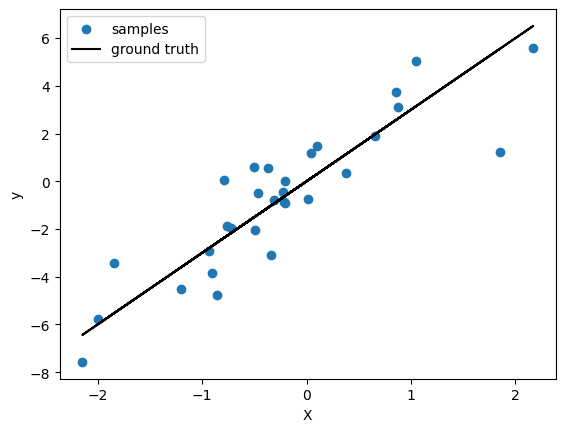

In [4]:
# plot the training data using matplotlib
plt.scatter(X, y,label='samples')

# label the axes
plt.xlabel('X')
plt.ylabel('y');

# plot the noiseless data (the ground truth)
plt.plot(X, coefficient * X, c='k',label='ground truth')
plt.legend();

**Question 1.2** Write a function to compute the least-square regression using the closed form you have seen in class.

This function should minimize the least squares loss for the parameterized function $\hat{y} = \hat{a} \cdot x$.
Note that you can use functions from `np.linalg` to invert matrices etc.

In [5]:
# Write a function to compute the linear-regression predictor in closed form
def linear_regression(X : np.ndarray, y : np.ndarray) -> np.ndarray:
    """
    arguments:
        - X : data matrix
        - y : output
    returns:
        - a : the least square estimator
    """
    a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return a

In [6]:
# Print the predicted weights (coefficient + bias)
a_hat = linear_regression(X, y)
assert a_hat.shape == (1,), "You did not get a single value out to estimate a - this is wrong!"
print(f"We predicted a_hat={a_hat[0]} for the coefficient, while the ground truth is a={coefficient}.") # the notation with the f"I will print the {variable}." lets you easily print text.

We predicted a_hat=2.72955239932338 for the coefficient, while the ground truth is a=3.


**Question 1.3** Plot your training set and the ground truth function again, but this time also plot the predicted function $\hat{y} = \hat{a}\cdot x$. Don't forget to add axes labels and a legend.

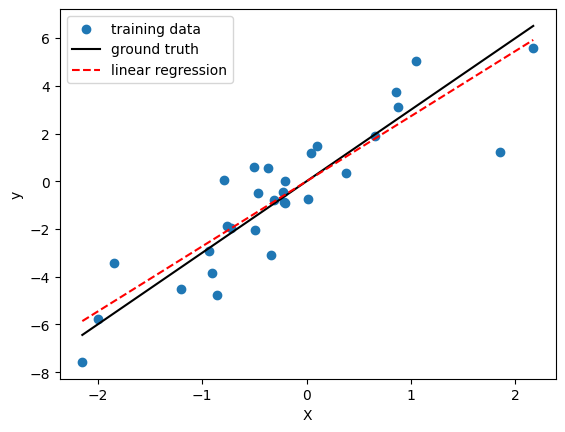

In [7]:
# Plot the training points and the predictor evaluated on a set of test points

X_test = np.linspace(np.min(X), np.max(X), 10)

plt.scatter(X, y,label='training data')
plt.plot(X_test, coefficient * X_test, 'k',label='ground truth')
plt.plot(X_test,  a_hat[0] * X_test, 'r--',label='linear regression')
plt.xlabel('X')
plt.ylabel('y');
plt.legend();

**Question 1.4** Now estimate $a$ with the `LinearRegression` object of the module [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Google how to use it correctly, and check that the coefficients from your direct implementation and the modules implementation are the same.

*Hint*: In the case here, we are **not** fitting the bias $b$ in the general linear regression of the form $y = ax+b$. What do you need to change when you call the sklearn function? Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) carefully.

In [8]:
# Repeat with Scikit-learn
linear_regression_sk = LinearRegression(fit_intercept=False)
linear_regression_sk.fit(X, y)
print('sklearn : ', linear_regression_sk.coef_[0])
print('own implementation : ', a_hat[0])

sklearn :  2.7295523993233815
own implementation :  2.72955239932338


# Exercise 2: Fitting physical data with Linear and Polynomial Regression

The superconductivity dataset [1] contains 81 chemical and molecular features extracted from >20,000 superconductors along with the critical temperature (the label) in the 82nd column. 
The goal is to predict the critical temperature $T_c$ based on the 81 first features. 
If you are interested by the physical meaning of those 81 features, check out the [original paper](https://arxiv.org/pdf/1803.10260.pdf)!

[1] Hamidieh, Computational Materials Science, 2018

First, you need to download the dataset, in .csv format. You can find it here : https://archive.ics.uci.edu/dataset/464/superconductivty+data or in the zip file/github repository.

Now, load the data into the notebook. Since the format is `.csv` (data table), we used the Python module called `pandas`. If you are locally running the notebook, you need to indicate the path to it, e.g. "Downloads/train.csv". 
On noto (the go-epfl link), you should see the train.csv already in your folder, so no need to download it.

In [9]:
import pandas as pd
dataset=pd.read_csv("train.csv",index_col=None) # todo: optionally change "train.csv" to the location of the file you downloaded yourself

using .values() converts the table into a numpy array . Since the last column is the label $T_c$, we have for the complete dataset our X's and y's are the following.

In [10]:
X = dataset.values[:,:-1]
y = dataset.values[:,-1]

**Question 2.1** Print the number of features and datapoints in the dataset. Verify that there are 81 features and get the exact number of datapoints.

In [11]:
n_samples = X.shape[0]
n_features = X.shape[1]
print(f"There are {n_features} features and {n_samples} dataspoints.")

There are 81 features and 21263 dataspoints.


**Question 2.2**  As discussed in class, when we work with applications, we usually split the data in three parts:
- The *training* dataset: We use it to fit the model parameters.
- The *validation* dataset: We use it to tune hyperparameters and select models.
- The *test* dataset: We use it to evaluate the final performance on unseen data.
  
We need three sets because if we tuned hyperparameters directly on the test set, the model could overfit to the test set. The validation set acts as an intermediate hold-out for model selection, and the test set is kept untouched until the very end to give an unbiased estimate of the generalization performance.

In the following, use the `train_test_split` function from sklearn to randomly split the complete dataset into three parts : 60% into train, 20% into validation, and 20% into test.

In [12]:
from sklearn.model_selection import train_test_split

rs = np.random.RandomState(23) # introducing this to make the solution give the same result every time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=23)

print(f"X_train contains {X_train.shape[0]/n_samples*100:.1f}% of the data, "
      f"X_validation contains {X_validation.shape[0]/n_samples*100:.1f}%, "
      f"and X_test contains {X_test.shape[0]/n_samples*100:.1f}%.")

X_train contains 60.0% of the data, X_validation contains 20.0%, and X_test contains 20.0%.


Because different features correspond to different physical quantities and have different units, thus different magnitudes of numerical values, we preprocess the array so that the entries of the vector are of the same order of magnitude.

Since we are assuming that we only have the training dataset available to train the model, we compute the statistics based on the `X_train` dataset, and then use them to rescale the valiation and test data. The `StandardScaler` from sklearn uses the fit-predict framework.

Once the renormalization is done we do not need to worry about it anymore.

In [13]:
# record the statistics
scaler_X = preprocessing.StandardScaler().fit(X_train)
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))

# rescale the data
X_test=scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
X_train=scaler_X.transform(X_train)
y_train = scaler_y.transform(y_train.reshape(-1,1)).reshape(-1)
X_validation=scaler_X.transform(X_validation)
y_validation = scaler_y.transform(y_validation.reshape(-1,1)).reshape(-1)

**Question 2.3** 
Your goal is now to fit the model using a linear regression, and evaluate its performance in predicting the critical temperature (the label y), i.e. xxx


a) How many parameters does your model have? This time we will include the bias term (or intercept).

In [14]:
print(f"A linear regression model for the superconductor dataset would have {n_features+1} parameters.")

A linear regression model for the superconductor dataset would have 82 parameters.


b) Fit the model using the LinearRegression module from sklearn, remember that this time we want the bias/intercept, and obtain a prediction for the data from the training and the validation set. Familiarize yourself with sklearns fit/predict framework.

In [15]:
# Perform linear regression on the training set
linear_regression_sk = LinearRegression()
linear_regression_sk.fit(X_train, y_train)

y_train_pred = linear_regression_sk.predict(X_train)
y_val_pred = linear_regression_sk.predict(X_validation)

c) Compute the mean squared error (MSE) between the label that we predict with the linear regression on the ground truth values from the validation and training set respectively. Which of the two MSE's do you expect to be better?

In [16]:
print("We expect the MSE on the training data to be smaller, since this is what we directly optimized for with the linear regression. ")
print(f"Indeed, we obtain a MSE of {mean_squared_error(y_validation, y_val_pred)} on the validation set, and {mean_squared_error(y_train, y_train_pred)} on the training set.")

We expect the MSE on the training data to be smaller, since this is what we directly optimized for with the linear regression. 
Indeed, we obtain a MSE of 0.27421938358793513 on the validation set, and 0.26109743102074356 on the training set.


d) Compare the predicted and actual values in the validation set with one another in a plot. This means that we want to plot points $(y,\hat{y})$ for all items from the validation set. If a prediction is correct the point lies on the diagonal, therefore also include the diagonal plotted as a line. Would you say you obtained a good fit?

(-2.0, 4.0)

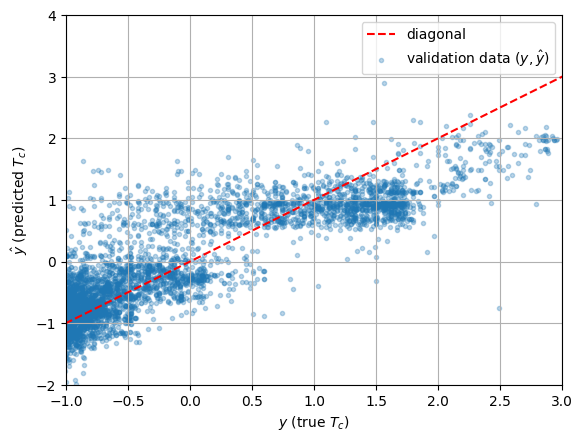

In [17]:
plt.plot(np.linspace(np.min(y_validation),np.max(y_validation),100),np.linspace(np.min(y_validation),np.max(y_validation),100),ls="--",c="r", label='diagonal')
plt.scatter(y_validation, y_val_pred, marker='.',alpha=0.3,label='validation data $(y,\hat{y})$')
plt.xlabel('$y$ (true $T_c$)')
plt.grid()
plt.ylabel('$\hat{y}$ (predicted $T_c$)');
plt.legend()
plt.xlim(-1,3)
plt.ylim(-2,4)

**Question 2.4**  We now consider having a only a smaller subset of the same dataset available, with only `n=400` training datapoints. We want to understand if in this case, regularization as seen in the lecture can help us to obtain a better model.

We consider Ridge regression with the regularization parameter $\lambda$, where the matrix that we want to invert is not $X^TX$ directly, but instead $X^TX + \lambda I$.

a) Replace the linear regression from 2.3b) with the Ridge regression class from the sklearn library and use  $\lambda\in\{10,1\}$. Compute the training and validation error for each. Which of the two $\lambda$'s would you use?

*Hint:* Check the documentation of the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) class to understand how you set $\lambda$.

In [18]:
n = 400 

ridge_regression_sk = Ridge(alpha=10.0)
ridge_regression_sk.fit(X_train[:n], y_train[:n])

y_train_pred = ridge_regression_sk.predict(X_train[:n])
mse_train = mean_squared_error(y_train[:n], y_train_pred)

y_validation_pred = ridge_regression_sk.predict(X_validation)
mse_val = mean_squared_error(y_validation, y_validation_pred)

print(f"For lambda=10: MSE [train={mse_train}], MSE [val={mse_val}].")

ridge_regression_sk = Ridge(alpha=1.0)
ridge_regression_sk.fit(X_train[:n], y_train[:n])

y_train_pred = ridge_regression_sk.predict(X_train[:n])
mse_train = mean_squared_error(y_train[:n], y_train_pred)

y_validation_pred = ridge_regression_sk.predict(X_validation)
mse_val = mean_squared_error(y_validation, y_validation_pred)

print(f"For lambda=1: MSE [train={mse_train}], MSE [val={mse_val}].")
print("Since the validation error for lambda=1 is better, I would use this model.")

For lambda=10: MSE [train=0.3148249847035344], MSE [val=0.3225242542820293].
For lambda=1: MSE [train=0.282028916117119], MSE [val=0.3133826635701197].
Since the validation error for lambda=1 is better, I would use this model.


b) Repeat this experiment for several lambdas, `lmbdas = np.logspace(2,-5,50)`, and record the associated training and validation errors in a list.

In [19]:
train_errors = []
validation_errors = []
lmbdas = np.logspace(2,-5,50)

for lmbda in lmbdas:
    ridge_regression_sk = Ridge(alpha=lmbda)
    ridge_regression_sk.fit(X_train[:n], y_train[:n])

    y_train_pred = ridge_regression_sk.predict(X_train[:n])
    train_errors.append(mean_squared_error(y_train[:n], y_train_pred))

    y_validation_pred = ridge_regression_sk.predict(X_validation)
    validation_errors.append(mean_squared_error(y_validation, y_validation_pred))

c) Plot the train and validation error over the lambdas to observe that there is a minimum of the validation error in terms of lambda. Identify the best lambda for this model, and mark it on the same plot.

Text(0, 0.5, 'MSE')

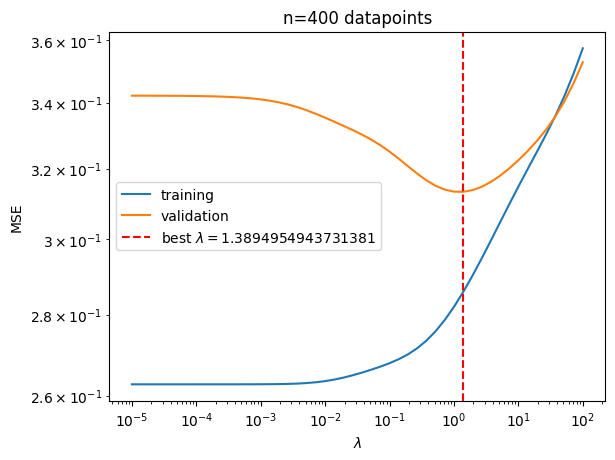

In [20]:
plt.plot(lmbdas,train_errors,label='training')
plt.plot(lmbdas,validation_errors,label='validation')
best_lmbda_idx = np.argmin(validation_errors)
best_lmbda = lmbdas[best_lmbda_idx]

plt.axvline(best_lmbda,color='red',linestyle='dashed',label=f'best $\lambda={best_lmbda}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('$\lambda$')
plt.title(f"n={n} datapoints")
plt.ylabel('MSE')

d) Print the generalization error of the model you selected. Which dataset do you need to use to estimate it and why?

In [21]:
ridge_regression_sk = Ridge(alpha=best_lmbda)
ridge_regression_sk.fit(X_train[:n], y_train[:n])

y_test_pred = ridge_regression_sk.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"The finally selected model achieves an estimated generalization error via the test set as {mse_test}.")
print("Since we used the validation set during model (hyperparameter) selection, we cannot use it to get an unbiased estiamte of the generalization error.")

The finally selected model achieves an estimated generalization error via the test set as 0.3019446227645591.
Since we used the validation set during model (hyperparameter) selection, we cannot use it to get an unbiased estiamte of the generalization error.


**Question 2.5** We now want to understand more broadly how the number of samples and the selection of the best $\lambda$ relate to one another.

a) For the different values of $\lambda \in \{10000,100,1,0.0001\}$. Plot the train and validation error over the different `n` from `trainset_sizes`, with a logscale on the x-axis.
Is there one lambda which is optimal for all `n`?

*Tip:* If you running the code takes too long, change the `100` in `np.logspace(0.5,5,100).astype(int)` to a smaller integer, then you will have less resolution on the x-axis, but you can debug your code faster.

No, the best value of lambda depends on n.


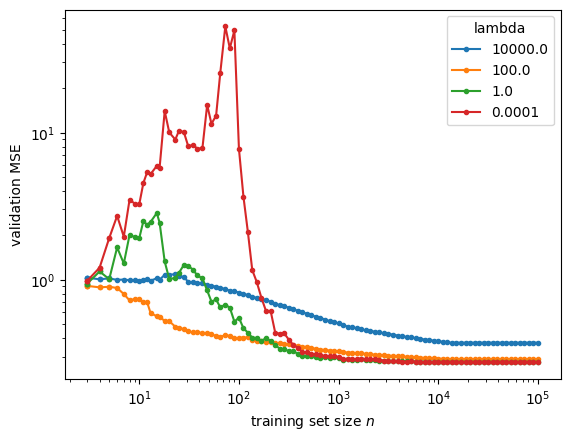

In [22]:
trainset_sizes = np.logspace(0.5,5,100).astype(int)

for lmbda in [10000.0,100.0,1.0,0.0001]:
    train_errors = []
    validation_errors = []
    
    for n in trainset_sizes:
        ridge_regression_sk = Ridge(alpha=lmbda)
        ridge_regression_sk.fit(X_train[:n], y_train[:n])

        y_train_pred = ridge_regression_sk.predict(X_train[:n])
        train_errors.append(mean_squared_error(y_train[:n], y_train_pred))

        y_validation_pred = ridge_regression_sk.predict(X_validation)
        validation_errors.append(mean_squared_error(y_validation, y_validation_pred))
        
    plt.plot(trainset_sizes, validation_errors, marker='.', label=lmbda)

plt.xlabel('training set size $n$')
plt.xscale("log")
plt.yscale('log')
plt.legend(title='lambda');
plt.ylabel('validation MSE')
    
print('No, the best value of lambda depends on n.')

b) For every dataset size `n` find the optimal $\lambda$ out of the `lmbdas` array that has the best validation error. 
Create two plots, with the x-axis always in log-scale:
- Plot the best models training and validation error over for every `n`, where `n` is the x-axis. 
- Plot the optimal $\lambda$ over `n` as the x-axis.
What do you observe for the optimal $\lambda$ as a function of $n$?

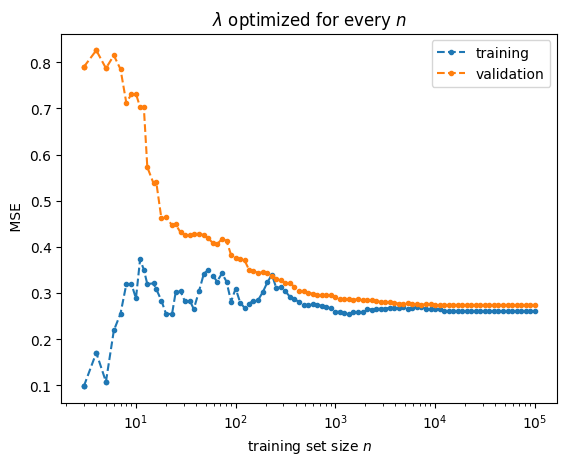

Text(0, 0.5, '$\\lambda$')

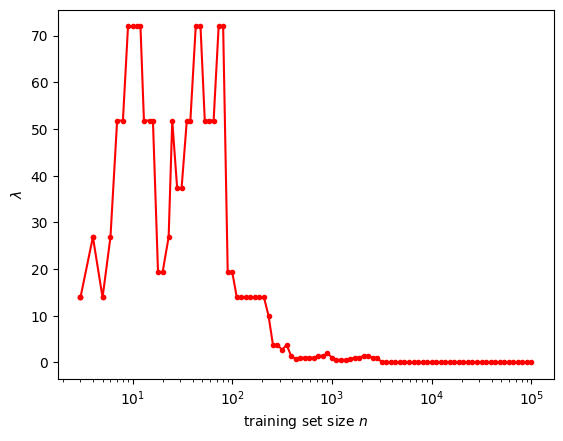

In [23]:
train_errors = []
validation_errors = []
optimal_lambda = []
lmbdas = np.logspace(2,-5,50)

for n in trainset_sizes:
    train_errors.append(np.inf)
    validation_errors.append(np.inf)
    optimal_lambda.append(None)
    for lmbda in lmbdas:
        ridge_regression_sk = Ridge(alpha=lmbda)
        ridge_regression_sk.fit(X_train[:n], y_train[:n])

        y_train_pred = ridge_regression_sk.predict(X_train[:n])
        mse_train = mean_squared_error(y_train[:n], y_train_pred)

        y_validation_pred = ridge_regression_sk.predict(X_validation)
        mse_val = mean_squared_error(y_validation, y_validation_pred)
        if mse_val <= validation_errors[-1]:
            validation_errors[-1] = mse_val
            train_errors[-1] = mse_train
            optimal_lambda[-1] = lmbda
            
plt.plot(trainset_sizes, train_errors, marker='.', label='training',c='tab:blue',linestyle='dashed')
plt.plot(trainset_sizes, validation_errors, marker='.', label='validation',c='tab:orange',linestyle='dashed')
plt.title('$\lambda$ optimized for every $n$')
plt.xlabel('training set size $n$')
plt.xscale("log")
plt.ylabel(' MSE')
plt.legend();
plt.show()

plt.plot(trainset_sizes,optimal_lambda,marker='.',c='red')
plt.xscale('log')
plt.xlabel('training set size $n$')
plt.ylabel('$\lambda$')


**Question 2.6** We now want to make the predictions better by making the model itself more powerful - the underlying relationships might not be only linear. This is why in this part of the exercise we introduce polynomial regression. (We go back to using the original train/test/val split with the full training set)

a) Implement a function that generates _non-interactive_ polynomial features : for a degree $k$ and an input $x = x_1, ..., x_d$, generate $\tilde x = x_1 / 1!, ..., x_1^k/k!, x_2/1!, ..., x_2^k/k!, ..., x_d^k/k!$.
The factorial ensures that the magnitude of the entries of $\tilde x$ are all of the same order, despite the power to the $k$.

In [24]:
from scipy.special import factorial

def non_interacting_polyfeat(X : np.ndarray, k : int) -> np.ndarray:
    """
    arguments: 
        - X : n x d matrix, where each row is a data sample
        - k : degree of the desired polynomial features
    returns: 
        - X_tilde : n x (dk) matrix containing the polynomial features
    """
    return np.concatenate([X**(i+1)/factorial(i+1) for i in range(k)], axis=1)

b) Then, fit a linear regression (no Ridge yet!) on these polynomial features with different degrees $k$. Plot the training and validation errors over the degree. Explain the phenomenon you observe.

We observe for some degree k we start overfitting the data: For $k$ large enough the training error is going down but validation error increases.


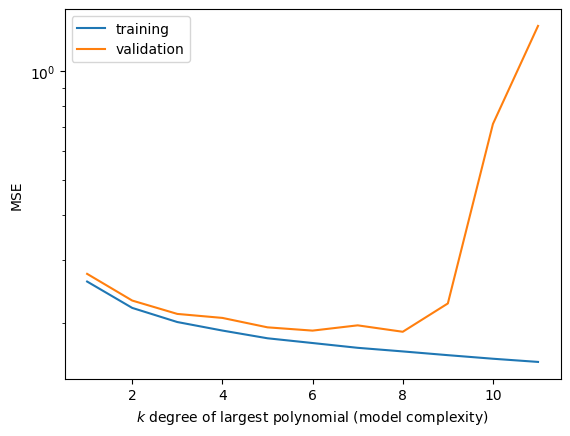

In [25]:
train_errors = []
val_errors = []

degrees = range(1, 12)
for degree in degrees:
    linear_regression_sk = LinearRegression()

    X_train_poly = non_interacting_polyfeat(X_train, degree)
    linear_regression_sk.fit(X_train_poly, y_train)

    y_train_pred_poly = linear_regression_sk.predict(X_train_poly)
    train_errors.append(mean_squared_error(y_train, y_train_pred_poly))

    y_val_pred_poly = linear_regression_sk.predict(non_interacting_polyfeat(X_validation, degree))
    val_errors.append(mean_squared_error(y_validation, y_val_pred_poly))

plt.semilogy(degrees, train_errors, label='training')
plt.semilogy(degrees, val_errors, label='validation')
plt.xlabel('$k$ degree of largest polynomial (model complexity)')
plt.ylabel('MSE')
plt.legend();

print("We observe for some degree k we start overfitting the data: For $k$ large enough the training error is going down but validation error increases.")

c) Select the best model from the above and compute its validation error, and plot the same $(y,\hat{y})$ as in 2.3d). Is the fit better than the simple linear regression on the full dataset?

Best degree is  8
The training error is 0.16719990909839644.
The validation error is 0.18952253866002225.
It is hard to tell the difference, so we have to rely on the validation MSE, which is siginificantly smaller.


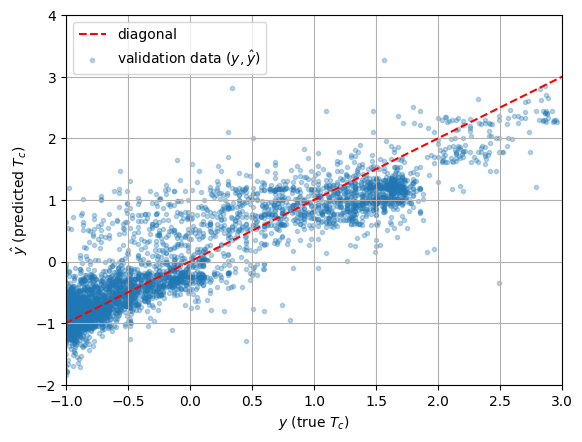

In [26]:
best_degree = degrees[np.argmin(val_errors)]
print('Best degree is ', best_degree)
X_train_poly = non_interacting_polyfeat(X_train, best_degree)
linear_regression_sk = LinearRegression() 
linear_regression_sk.fit(X_train_poly, y_train)

y_val_pred_poly = linear_regression_sk.predict(non_interacting_polyfeat(X_validation, best_degree))
y_train_pred_poly = linear_regression_sk.predict(non_interacting_polyfeat(X_train, best_degree))
print(f"The training error is {mean_squared_error(y_train, y_train_pred_poly)}.")
print(f"The validation error is {mean_squared_error(y_validation, y_val_pred_poly)}.")

plt.plot(np.linspace(np.min(y_validation),np.max(y_validation),100),np.linspace(np.min(y_validation),np.max(y_validation),100),ls="--",c="r", label='diagonal')
plt.scatter(y_validation, y_val_pred_poly, marker='.',alpha=0.3,label='validation data $(y,\hat{y})$')
plt.xlabel('$y$ (true $T_c$)')
plt.grid()
plt.ylabel('$\hat{y}$ (predicted $T_c$)');
plt.xlim(-1,3)
plt.ylim(-2,4)
plt.legend()
print("It is hard to tell the difference, so we have to rely on the validation MSE, which is siginificantly smaller.")

**Question 2.7** 

a) Pick again the best model between the different polynomial degrees and add a different regularisation strength $\lambda$ using the Ridge regression module again. Plot the training and test errors as a function of $\lambda$.

The best validation error is 0.19485388874941537


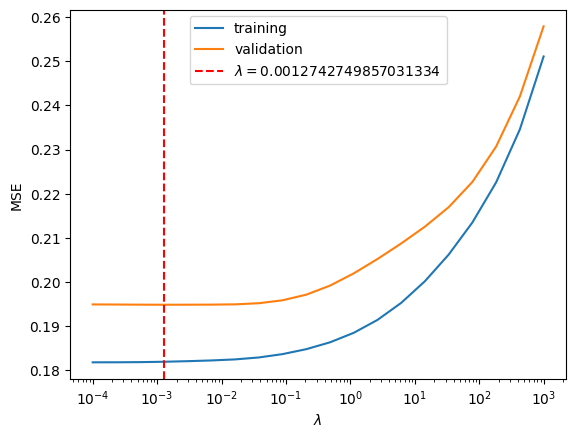

In [27]:
lmbdas = np.logspace(-4, 3, 20) # regularization parameters you are supposed to use
best_degree = 5
train_errors = []
val_errors_lambda = []

for lmbda in lmbdas:

    X_train_poly = non_interacting_polyfeat(X_train, k=best_degree)

    ridge_regression = Ridge(alpha=lmbda)
    ridge_regression.fit(X_train_poly, y_train)

    y_train_pred_poly = ridge_regression.predict(X_train_poly)
    train_errors.append(mean_squared_error(y_train, y_train_pred_poly))

    y_val_pred_poly = ridge_regression.predict(non_interacting_polyfeat(X_validation, k=best_degree))
    val_errors_lambda.append(mean_squared_error(y_validation, y_val_pred_poly))

plt.plot(lmbdas, train_errors, label='training')
plt.plot(lmbdas, val_errors_lambda, label='validation')
best_lmbda_idx = np.argmin(val_errors_lambda)
best_lmbda = lmbdas[best_lmbda_idx]
plt.axvline(best_lmbda,c='red',linestyle='dashed',label=f'$\lambda=${best_lmbda}')
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.xscale('log')
plt.legend();
print(f"The best validation error is {val_errors_lambda[best_lmbda_idx]}")

b) Compute the generalization error of the best ridge regression.

In [28]:
ridge_regression = Ridge(alpha=best_lmbda)
ridge_regression.fit(X_train_poly, y_train)

y_test_pred_poly = ridge_regression.predict(non_interacting_polyfeat(X_test, k=best_degree))
test_error = mean_squared_error(y_test, y_test_pred_poly)
print(f'The generalization error of the final selected model is estimated to be {test_error}.')

The generalization error of the final selected model is estimated to be 0.18519597075895486.


c) Your TA tells you they found a model that achieves a test error of 0.15 on the test dataset when they followed the train-validation-test pipeline like you did. 
- Between your model and their model, which would you choose to use in practice? 
- How can you estimate the generalization error of the model you choose? 

If I want to know the generalization error, I cannot choose based on the test set, since it must remain untouched for the final evaluation. Instead, I would select the model with lower validation error, then estimate its generalization error using the held-out test set again.

If I only have the test error information available from the TA I could still choose the one better one based on the test error, but then I cannot rely on the score on the "test dataset" as the final evaluator. I would need to obtain a new untouched dataset somewhere else to estimate an unbiased generalization error.